   #                                   MOM matching - pursuit

In [20]:
import nbimporter
import progressbar
import numpy as np
import sklearn.datasets as sk_data
import matplotlib.pyplot as plt
from math import inf
import numpy.random as alea
import random as rd
from procedure_MOM import procedure_MOM as PM
from Creation_de_base_aléatoire import base as base

In [21]:
%matplotlib notebook

In [22]:
n = 198
n_outliers = 2
features,sparsity = 50,10
sigma = 1
K = 5
iter_max = 200

t_0 = base.create_t_0(features,sparsity)
Y1,X1 = base.data1(n,t_0,sigma)
Y1,X1 = np.matrix(Y1),np.matrix(X1)
Y2,X2 = base.data2(n_outliers,features,type_outliers = 2)
Y2,X2 = np.matrix(Y2),np.matrix(X2)

Y,X = base.data_merge(Y1, X1, Y2, X2)

### Linear regression step by step, at each step, we add to the active set the variable most correlated with the residual and we make the regression on the residual.

In [23]:
def regression_by_step(X,Y) :
    
    n,p  =  np.shape(X)
    mu  =  np.zeros((n,1))
    beta  =  np.zeros((p + 1,p))
    corr  =  np.zeros((p + 1,p))
    A = []
    A_C = list(range(p))
    r = Y
    
    for k in range(p) :
        
        c = X.T * r
        corr[k] = c.T
        
        #Selection of the variable most correlated with the residual
        j = np.argmax(abs(c[A_C]))
        j = A_C[j]
        A.append(j)
        A_C.remove(j)
        
        X_A = X[ :,A]
        
        #Least square solution
        beta_k = np.linalg.solve(X_A.T * X_A,np.diag(np.ones(k + 1))) * X_A.T * Y
        
        beta[k + 1,A] = beta_k.reshape((1,len(A)))
        
        #Update of the residual
        r = Y - X * beta[k + 1].reshape((p,1))
    
    return beta,corr
    

### Test on diabete data

<IPython.core.display.Javascript object>


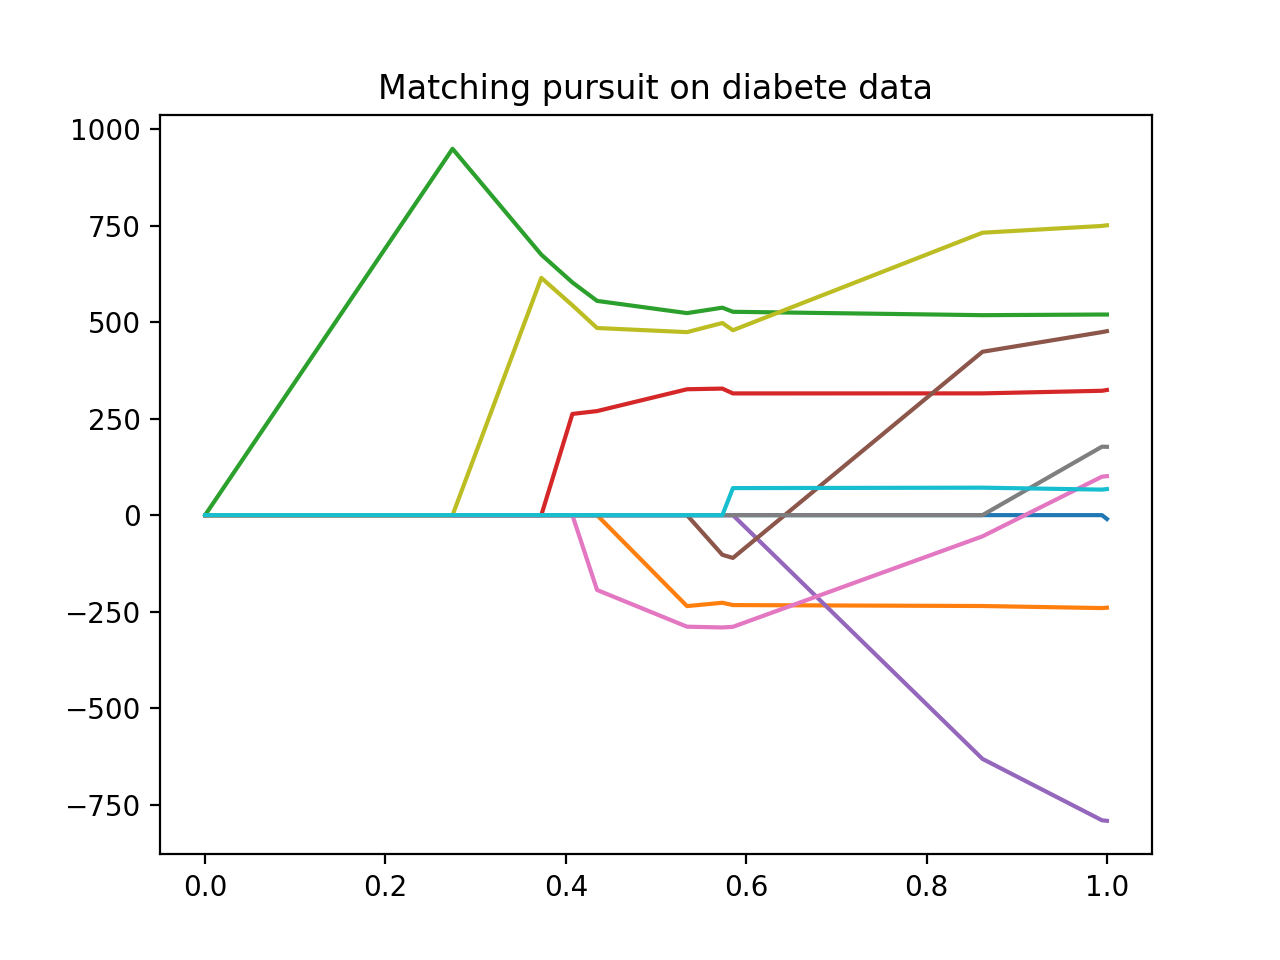

In [25]:
%matplotlib notebook

D = sk_data.load_diabetes()
D1 = D.data
D2 = D.target.reshape((442,1))
D1,D2 = np.matrix(D1),np.matrix(D2)

B,C = regression_by_step(D1,D2)

xx  =  np.sum(np.abs(B), axis = 1)
xx /= xx[ - 1]

plt.plot(xx,B)
plt.title("Matching pursuit on diabete data")
plt.show()

### MOM - matching pursuit.

In [26]:
def MOM_matching_pursuit(X,Y,K,iter_max,m) :
    
    n,p = np.shape(X)
    mu  =  np.zeros((n,1))
    beta  =  np.zeros((m + 1,p))
    A = []
    A_C = list(range(p))
    R = Y
    
    for l in range(m) :
        
        beta_l = beta[l].reshape((p,1))
        
        #Block selection
        k = PM.MOM_rand(np.multiply(R,R),K)[1]
        Xk = X[k]
        Rk = R[k]
        
        
        c = Xk.T * Rk
        
        #Selection of the variable most correlated with the residual
        j = np.argmax(abs(c[A_C]))
        j = A_C[j]
        A.append(j)
        A_C.remove(j)
        
        #Gradient descent
        beta_l = np.zeros((l + 1,1))
        
        for i in range(iter_max) :
            
            #Block selection
            k = PM.MOM_rand(np.multiply(R,R),K)[1]
            Xk = X[k]
            Yk = Y[k]
            
            beta_l = beta_l - (0.01 / np.sqrt(i + 1)) * PM.grad(Xk[ :,A],Yk,beta_l)
            
            R = Y - X[ :,A] * beta_l
            
        beta[l + 1][A] = beta_l.reshape((1,l + 1))
        
    return A,beta
        

In [27]:
def detec_supp_test(t_0,A,sparsity) :
    
    l = []
    p,_ = np.shape(t_0)
    
    for i in range(p) :
        
        if float(t_0[i]) != 0 :
            
            l.append(i)
            
    print("Non-zero elements of t_0 :",t_0[l])
    print("Elements of t_0 selected first by the algorithm :",t_0[list(set(A[ :sparsity]) & set(l))])
    print("Approximation of t_0 :",B[ - 1,l].reshape(sparsity, - 1))


In [29]:
def graph_supp_detection(t_0,B) :
    
    p,_ = np.shape(t_0)
    
    plt.figure(figsize  =  (15, 4))
    plt.stem(t_0, markerfmt = 'ro', label = 'true')
    plt.title('t_0')
    plt.figure(figsize  =  (15, 4))
    plt.stem(B[ - 1].reshape((p,1)),markerfmt = 'ro', label = 'true')
    plt.title('Approximation of t_0')

<IPython.core.display.Javascript object>


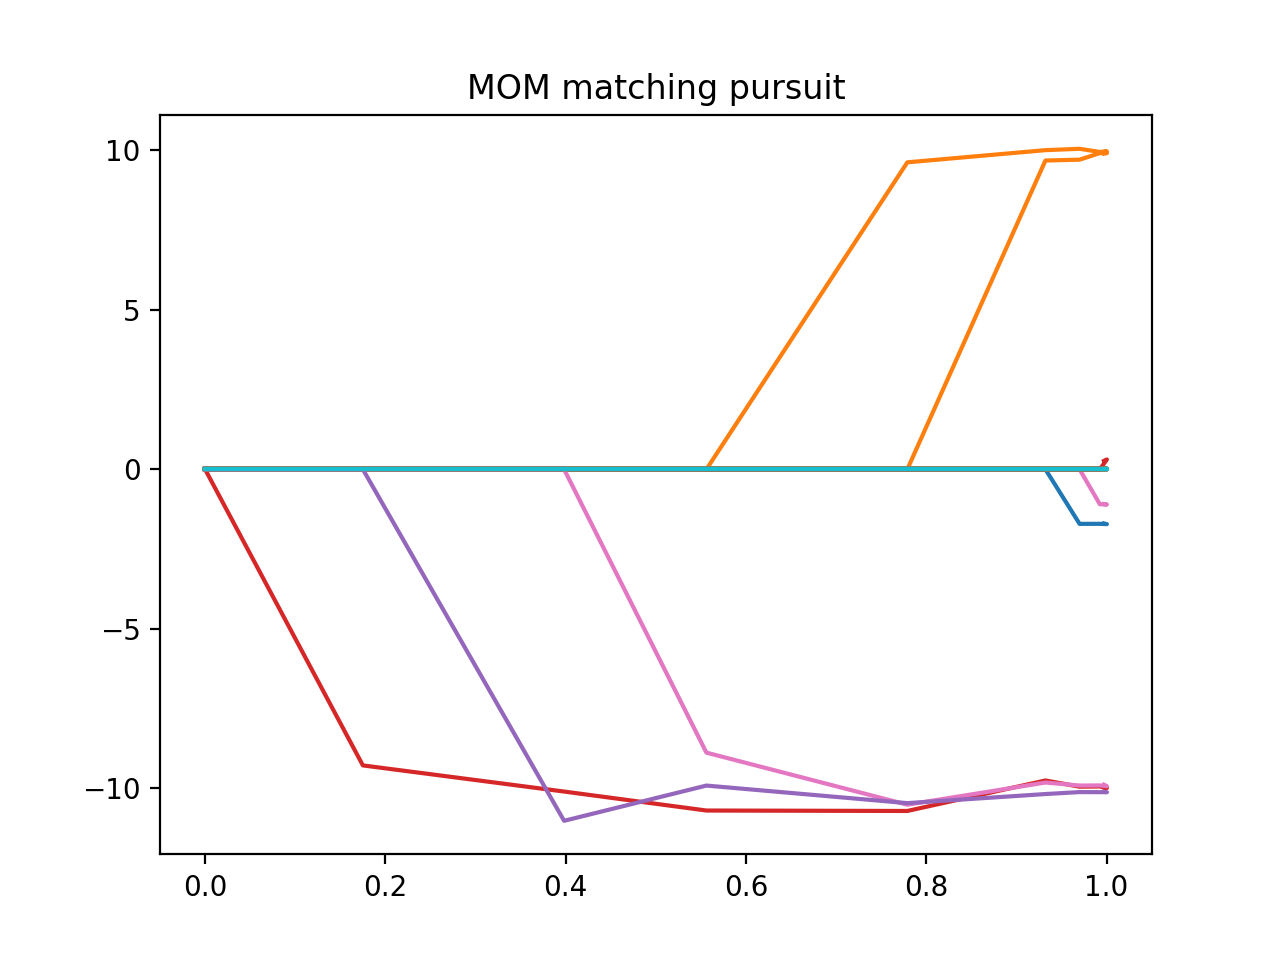

Non-zero elements of t_0 : [[ 10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [ -1.00948259]
 [  0.18441584]
 [-10.        ]
 [-10.        ]
 [  0.05554498]
 [ -0.05025918]]
Elements of t_0 selected first by the algorithm : [[ 10.        ]
 [  0.18441584]
 [-10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [-10.        ]
 [ -1.00948259]]
Approximation of t_0 : [[  9.91249913]
 [ -1.71954683]
 [ 10.02672185]
 [ -9.97251763]
 [ -1.08949201]
 [  0.2818638 ]
 [ -9.8480839 ]
 [-10.1104301 ]
 [  0.        ]
 [  0.        ]]


<IPython.core.display.Javascript object>


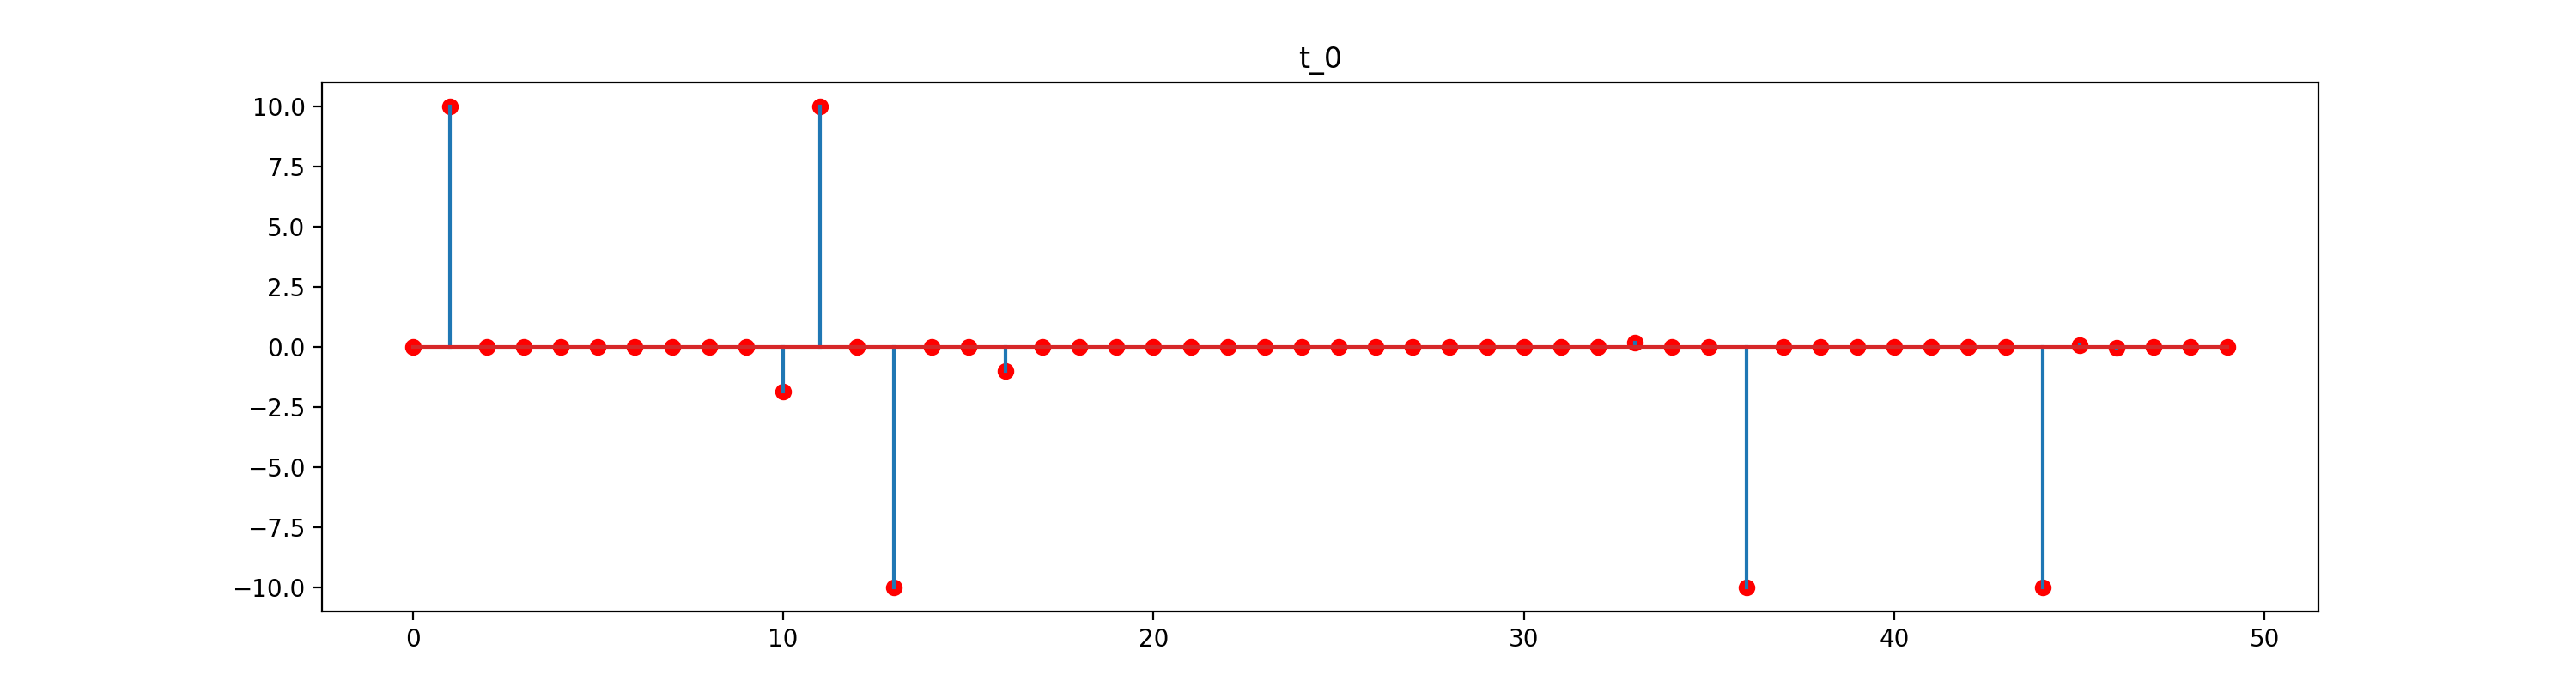

<IPython.core.display.Javascript object>


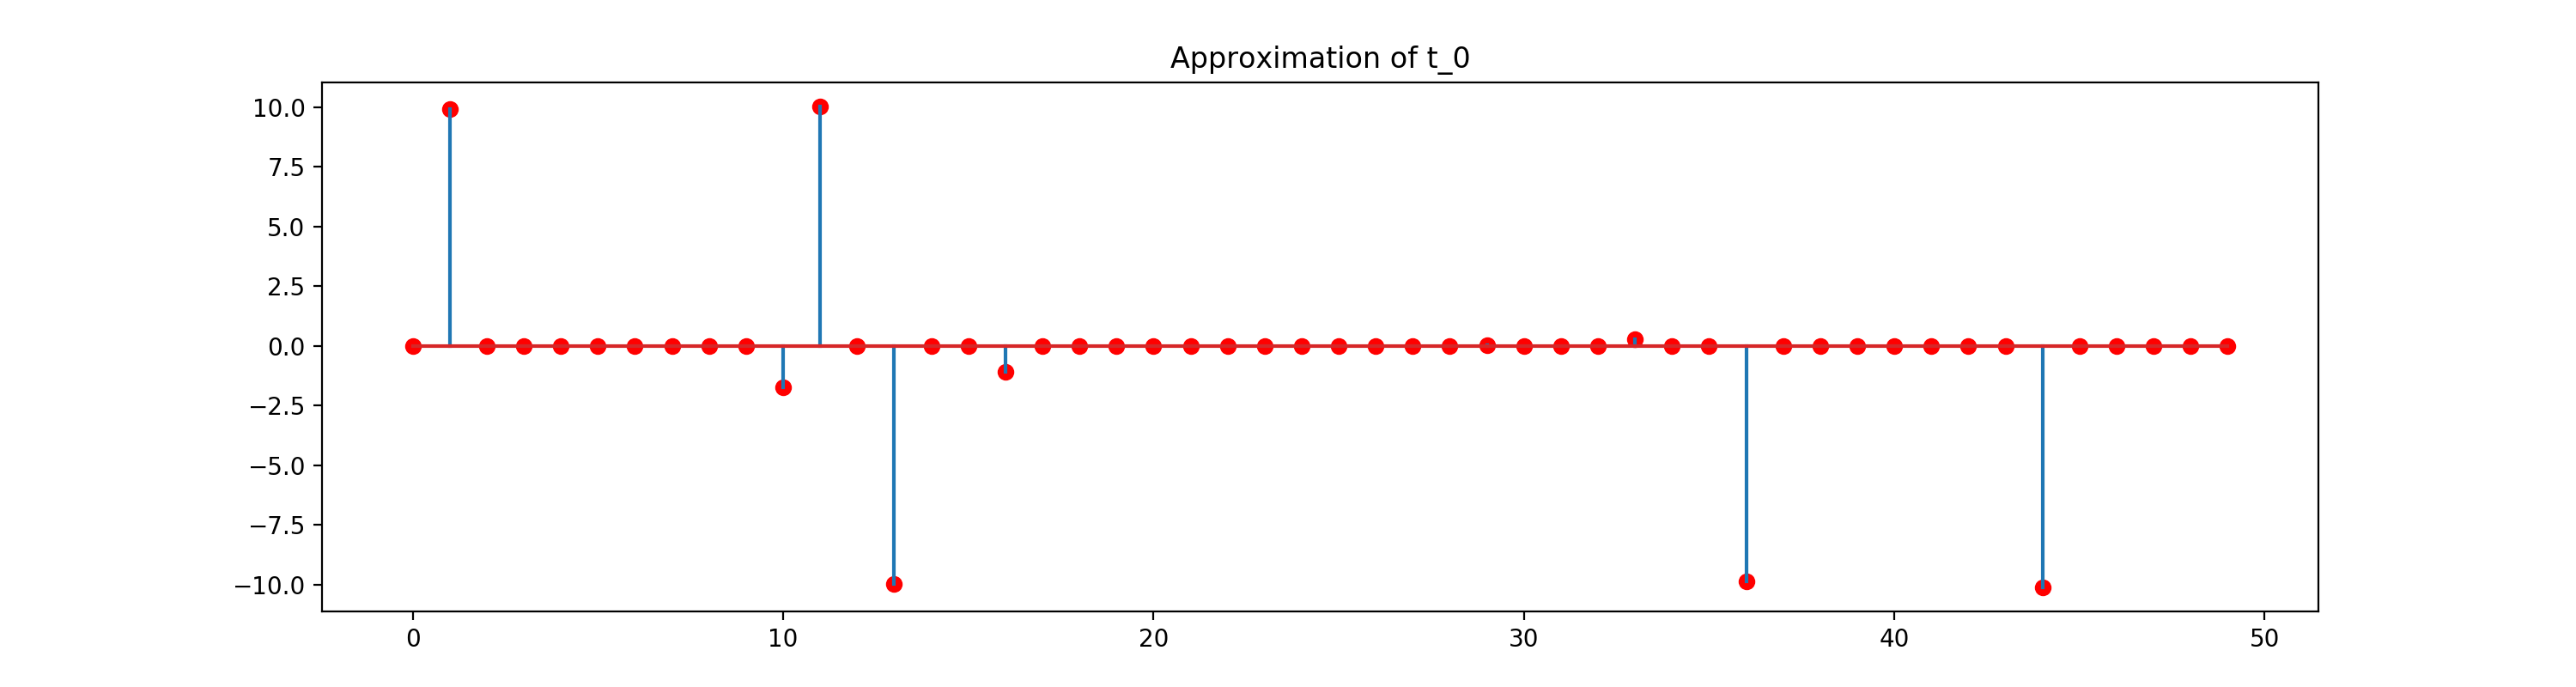

In [35]:
A,B = MOM_matching_pursuit(X,Y,8,iter_max,sparsity)

xx  =  np.sum(np.abs(B), axis = 1)
xx /= xx[ - 1]

plt.plot(xx[ : - 1],B[ : - 1])
plt.title("MOM matching pursuit")
plt.show()
detec_supp_test(t_0,A,sparsity)
graph_supp_detection(t_0,B)

### Gradient descent with backtracking line - search.

In [36]:
def LS_MOM_matching_pursuit(X,Y,K,iter_max,m,r) :
    
    n,p = np.shape(X)
    mu  =  np.zeros((n,1))
    beta  =  np.zeros((m + 1,p))
    A = []
    A_C = list(range(p))
    R = Y
    
    for l in range(m) :
        
        beta_l = beta[l].reshape((p,1))
        
        #Block selection
        k = PM.MOM_rand(np.multiply(R,R),K)[1]
        Xk = X[k]
        Rk = R[k]
        
        c = Xk.T * Rk
        
        #Selection of the variable most correlated with the residual
        j = np.argmax(abs(c[A_C]))
        j = A_C[j]
        A.append(j)
        A_C.remove(j)
        
        #Gradient descent with line search
        beta_l = np.zeros((l + 1,1))
        
        for i in range(iter_max) :
            
            #Block selection
            k = PM.MOM_rand(np.multiply(R,R),K)[1]
            Xk = X[k]
            Yk = Y[k]
            
            #Line search
            gamma = 1
            beta_l_prev = beta_l
            F = np.linalg.norm(Yk - Xk[ :,A] * beta_l_prev) ** 2
            NG = np.linalg.norm(PM.grad(Xk[ :,A],Yk,beta_l_prev)) ** 2
            
            beta_l = beta_l_prev - gamma * PM.grad(Xk[ :,A],Yk,beta_l_prev)
            delta = np.linalg.norm(Yk - Xk[ :,A] * beta_l) ** 2 - F + (gamma / 2) * NG
            
            while delta > 1e-3 :
                
                gamma *= r
                beta_l = beta_l_prev - gamma * PM.grad(Xk[ :,A],Yk,beta_l_prev)
                delta = np.linalg.norm(Yk - Xk[ :,A] * beta_l) ** 2 - F + (gamma / 2) * NG
                
            R = Y - X[ :,A] * beta_l
            
        beta[l + 1][A] = beta_l.reshape((1,l + 1))
        
    return A,beta
        

<IPython.core.display.Javascript object>


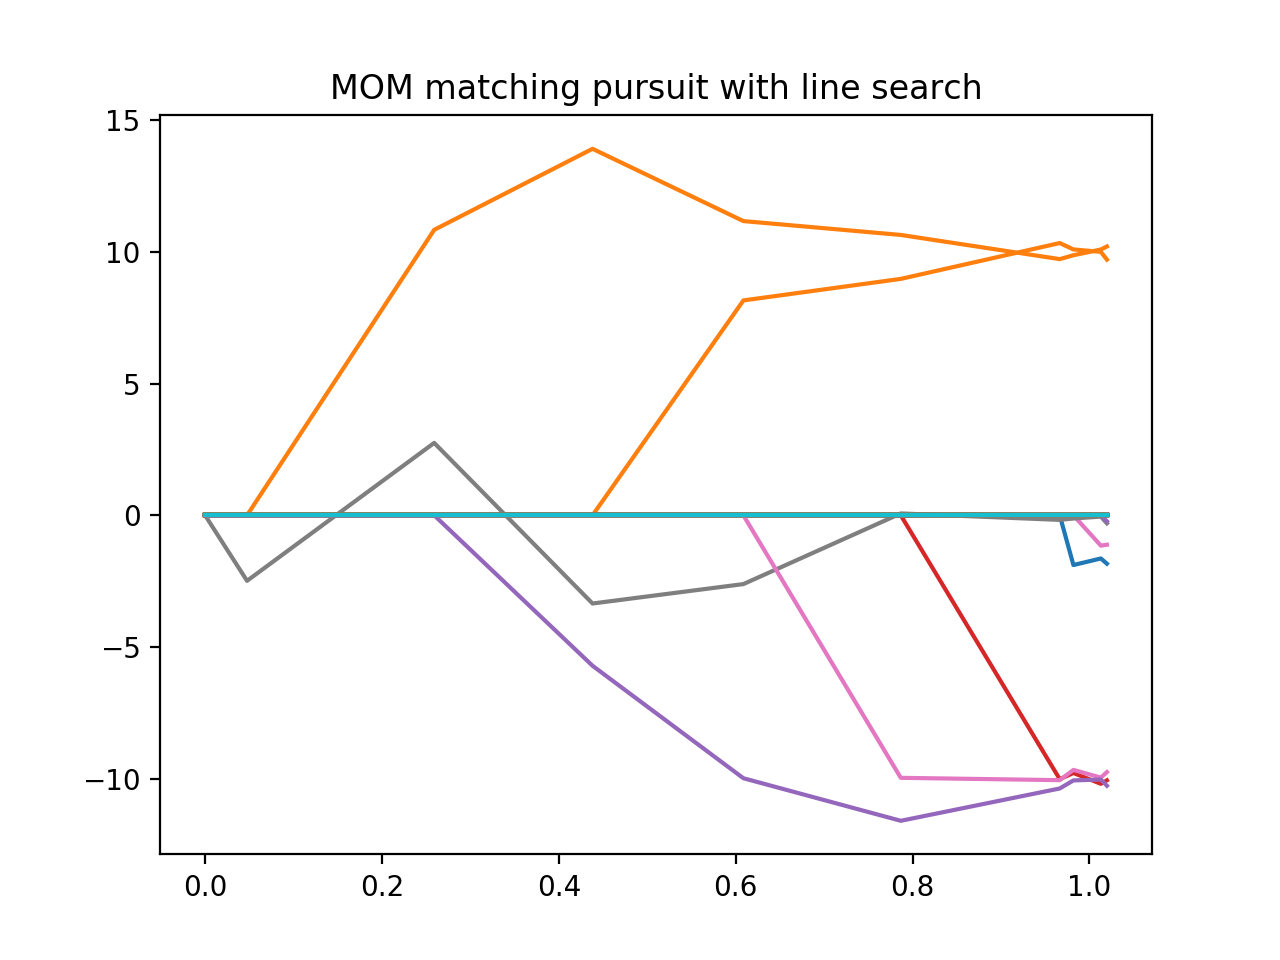

Non-zero elements of t_0 : [[ 10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [ -1.00948259]
 [  0.18441584]
 [-10.        ]
 [-10.        ]
 [  0.05554498]
 [ -0.05025918]]
Elements of t_0 selected first by the algorithm : [[ 10.        ]
 [-10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [-10.        ]
 [ -1.00948259]]
Approximation of t_0 : [[  9.69397219]
 [ -1.65619171]
 [ 10.05425917]
 [ -9.93588603]
 [ -1.04564666]
 [  0.        ]
 [ -9.59031484]
 [-10.06106961]
 [  0.        ]
 [  0.        ]]


<IPython.core.display.Javascript object>


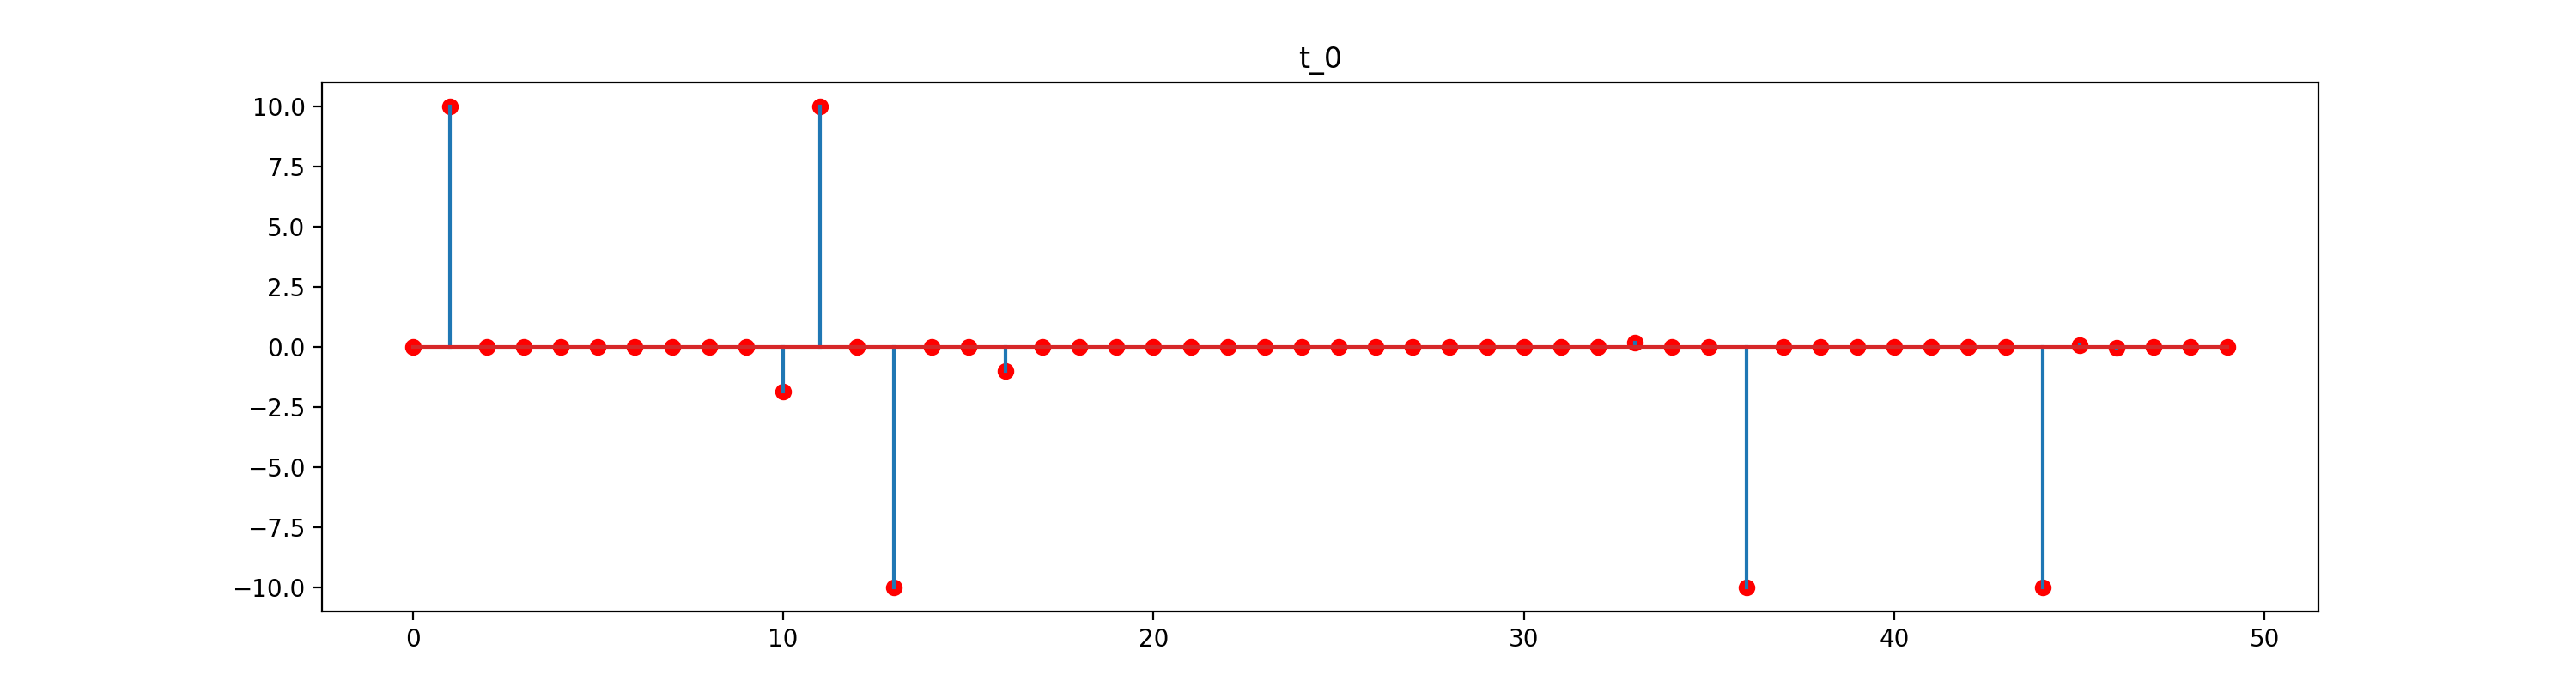

<IPython.core.display.Javascript object>


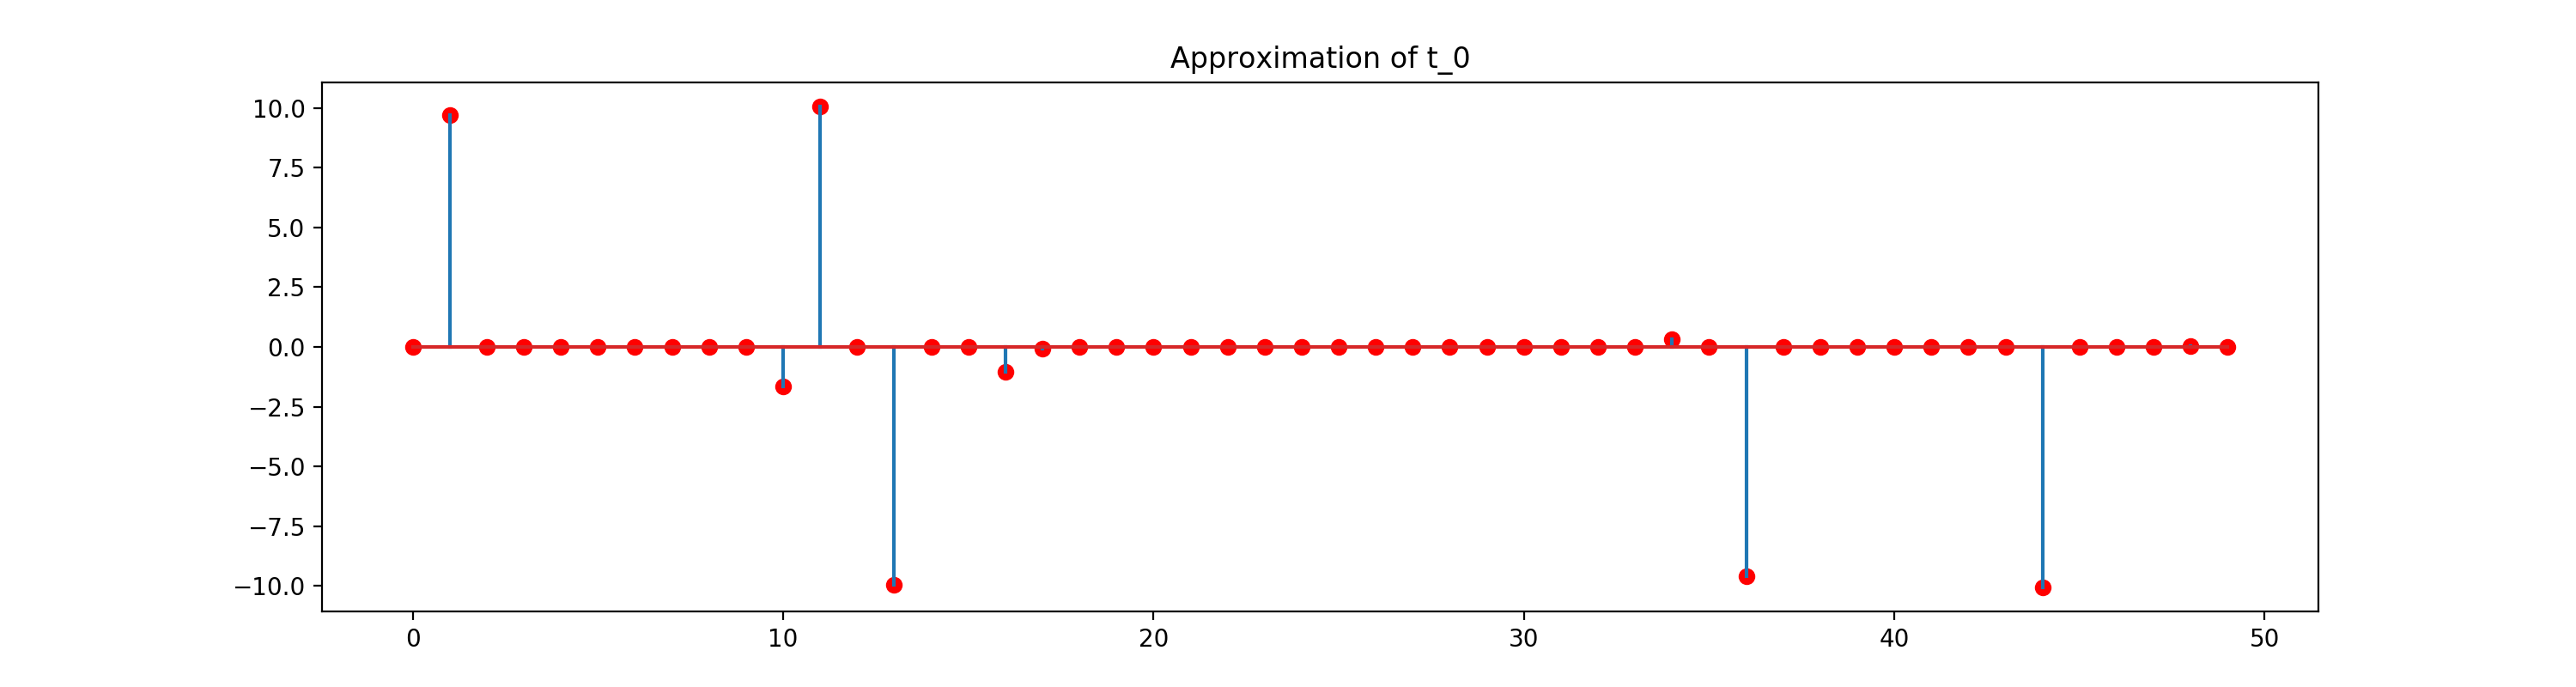

In [37]:
A,B = LS_MOM_matching_pursuit(X,Y,8,iter_max,10,1 / 1.2)

xx  =  np.sum(np.abs(B), axis = 1)
xx /= xx[ - 1]

plt.plot(xx[ : - 1],B[ : - 1])
plt.title("MOM matching pursuit with line search")
plt.show()

detec_supp_test(t_0,A,sparsity)
graph_supp_detection(t_0,B)

In [38]:
def FISTA_MOM_matching_pursuit(X,Y,K,iter_max,m) :
    
    n,p = np.shape(X)
    mu  =  np.zeros((n,1))
    beta  =  np.zeros((m + 1,p))
    A = []
    A_C = list(range(p))
    R = Y
    
    for l in range(m) :
        
        beta_l = beta[l].reshape((p,1))
        
        #Block selection
        k = PM.MOM_rand(np.multiply(R,R),K)[1]
        Xk = X[k]
        Rk = R[k]
        
        c = Xk.T * Rk
        
        #Selection of the variable most correlated with the residual
        j = np.argmax(abs(c[A_C]))
        j = A_C[j]
        A.append(j)
        A_C.remove(j)
        
        #Gradient descent
        beta_l = np.zeros((l + 1,1))
        aux_l = np.zeros((l + 1,1))
        
        for i in range(iter_max) :
            
            #Block selection
            k = PM.MOM_rand(np.multiply(R,R),K)[1]
            Xk = X[k]
            Yk = Y[k]
            
            gamma = float(1 / (np.linalg.norm(Xk)**2))
            beta_l_prev = beta_l
            
            beta_l = aux_l - gamma * PM.grad(Xk[ :,A],Yk,aux_l)
            aux_l = beta_l + (i / (i + 3)) * (beta_l - beta_l_prev)
            
            #print(beta_l)
            
            R = Y - X[ :,A] * beta_l
            
        beta[l + 1][A] = beta_l.reshape((1,l + 1))
        
    return A,beta
        

<IPython.core.display.Javascript object>


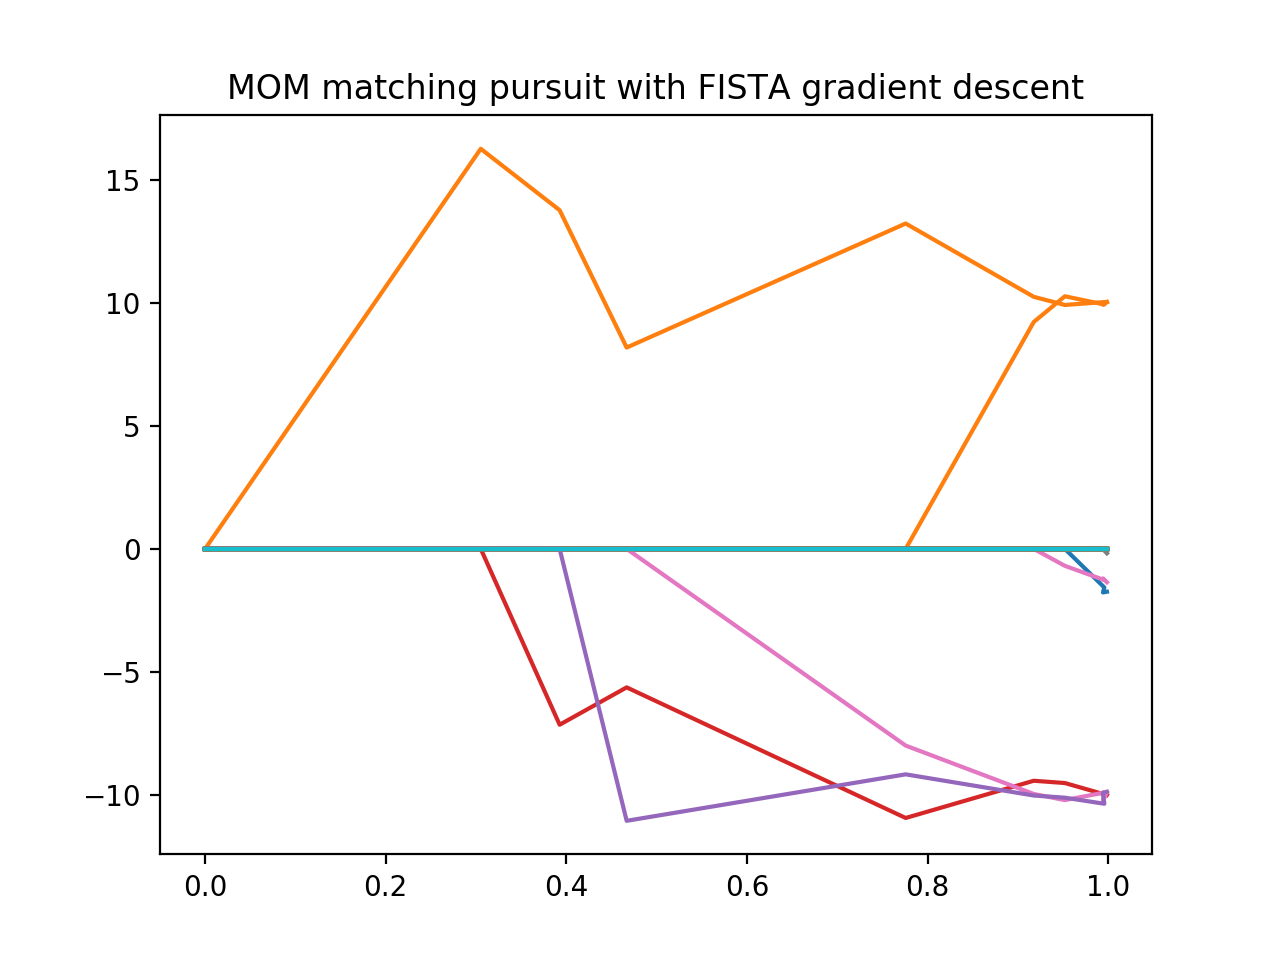

Non-zero elements of t_0 : [[ 10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [ -1.00948259]
 [  0.18441584]
 [-10.        ]
 [-10.        ]
 [  0.05554498]
 [ -0.05025918]]
Elements of t_0 selected first by the algorithm : [[ 10.        ]
 [-10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [-10.        ]
 [  0.05554498]
 [ -1.00948259]]
Approximation of t_0 : [[  9.94187479]
 [ -1.93181324]
 [ 10.08015964]
 [ -9.87266405]
 [ -1.05993114]
 [  0.        ]
 [ -9.81251607]
 [-10.15903531]
 [  0.16213433]
 [  0.        ]]


<IPython.core.display.Javascript object>


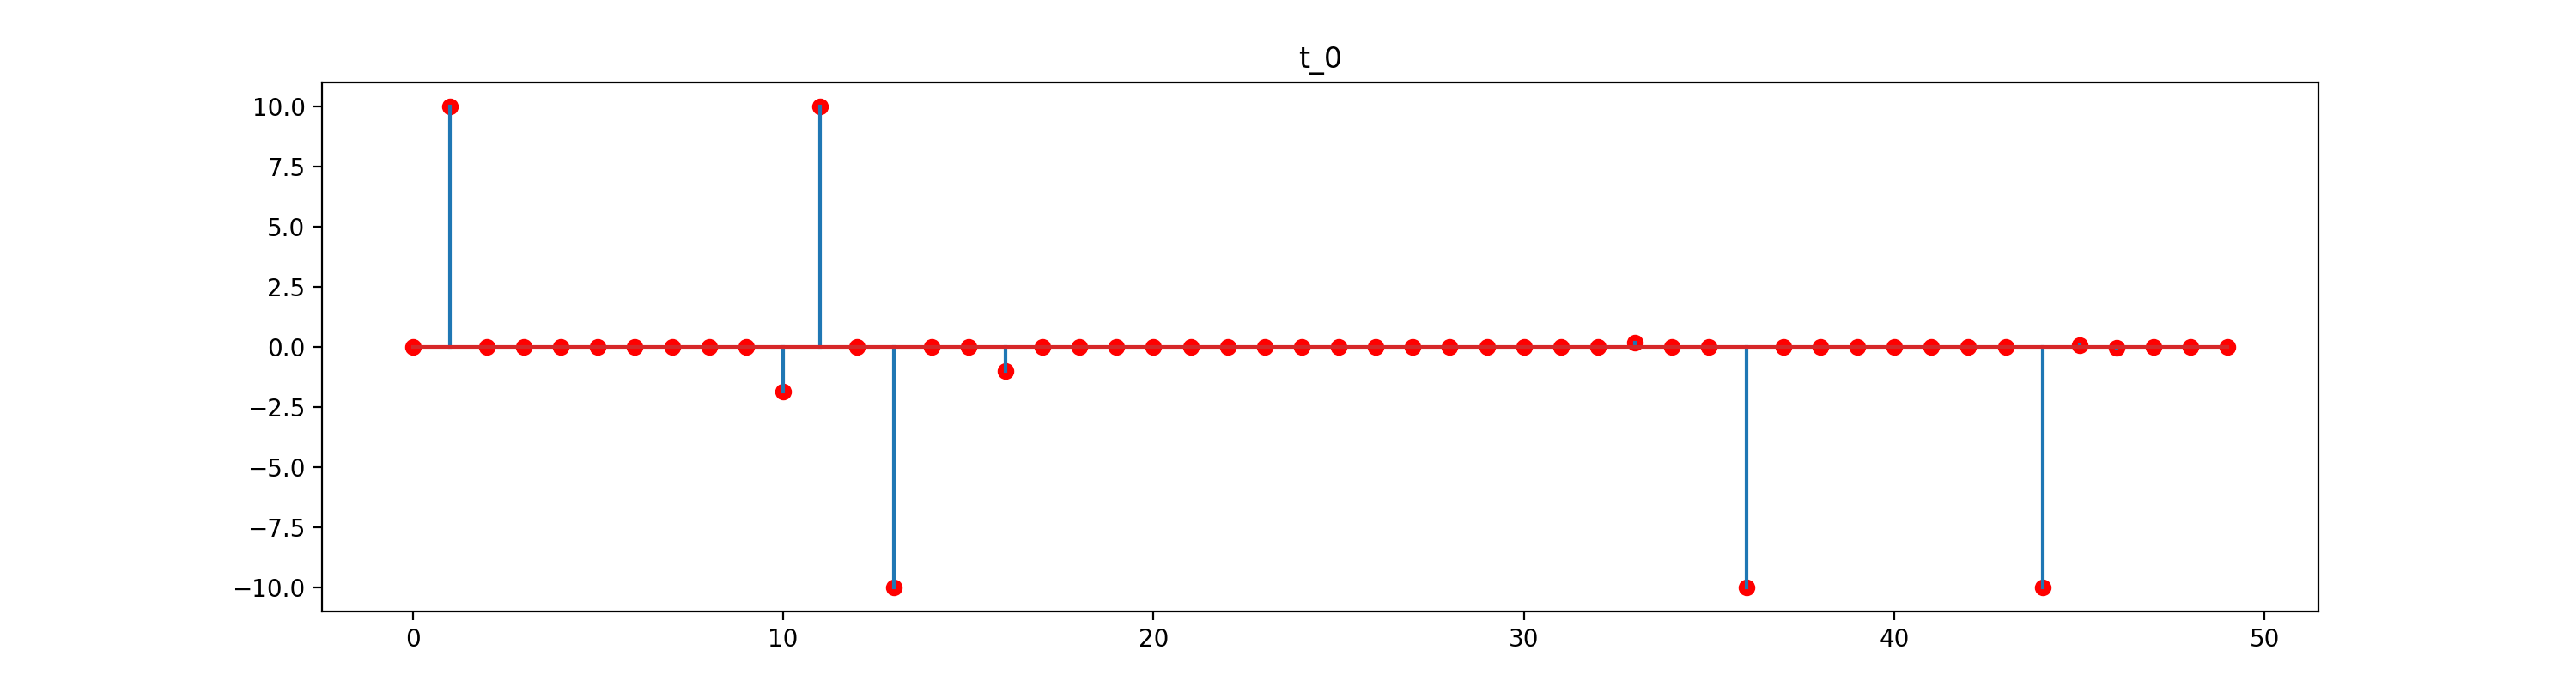

<IPython.core.display.Javascript object>


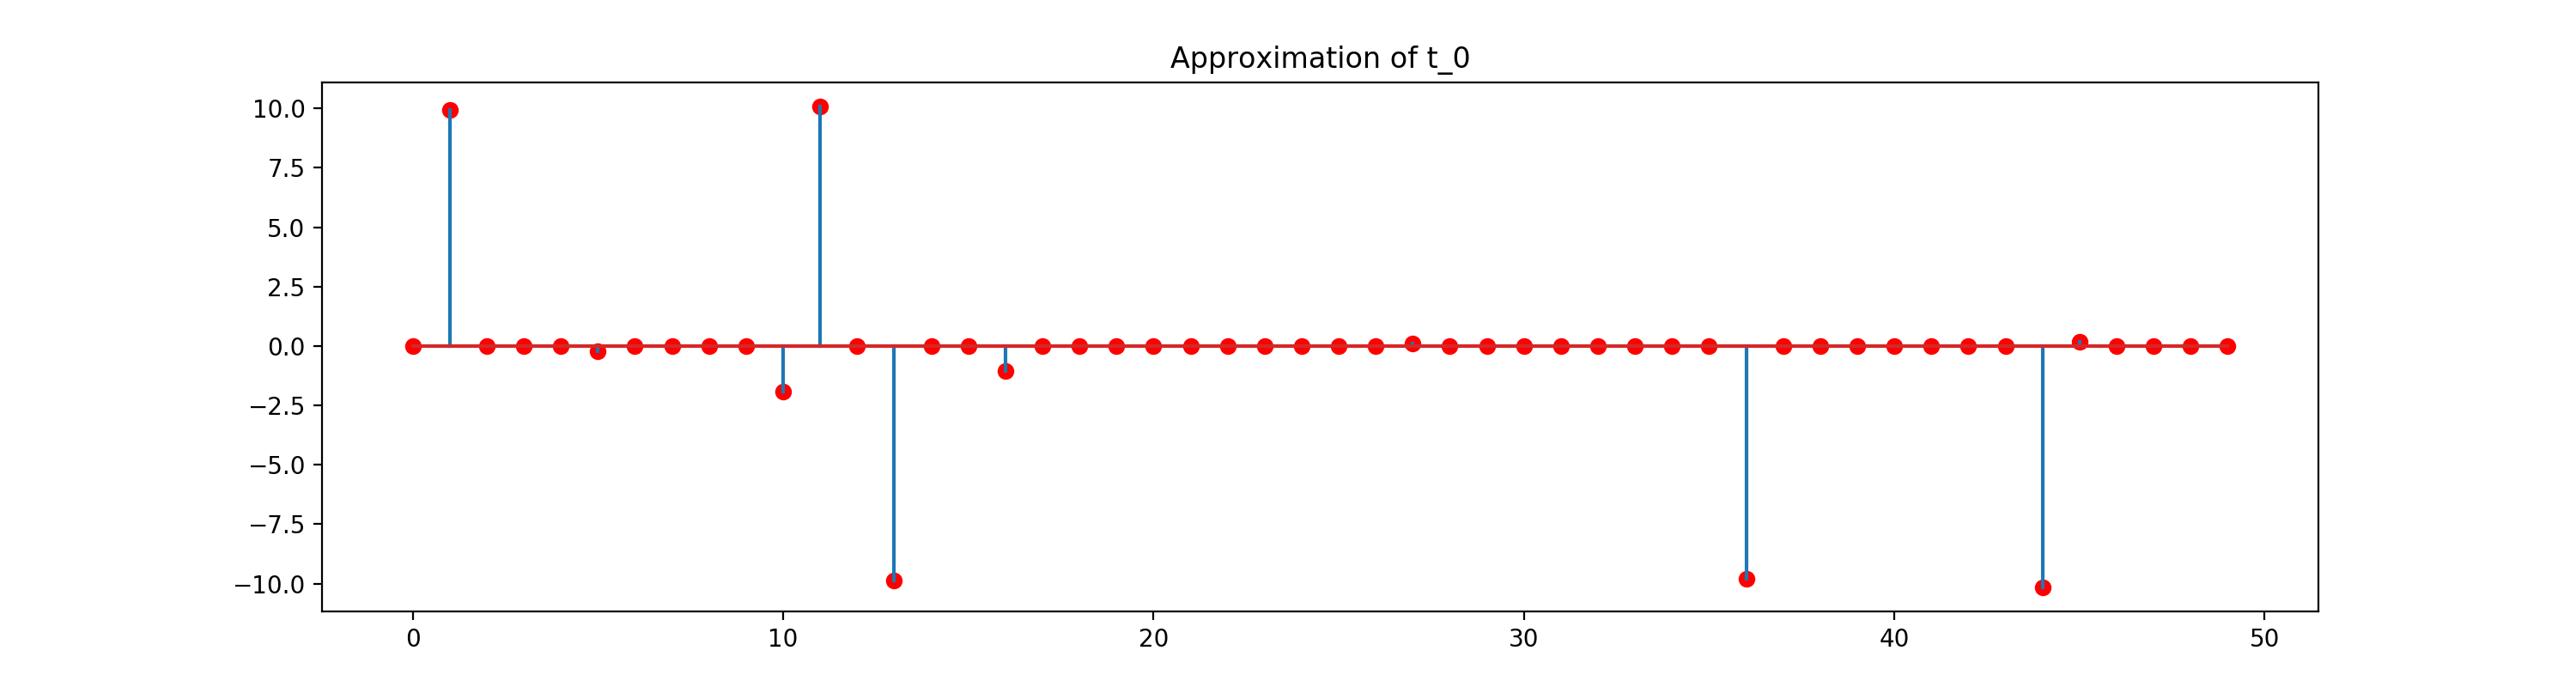

In [40]:
A,B = FISTA_MOM_matching_pursuit(X,Y,10,iter_max,10)

xx  =  np.sum(np.abs(B), axis = 1)
xx /= xx[ - 1]

plt.plot(xx[ : - 1],B[ : - 1])
plt.title('MOM matching pursuit with FISTA gradient descent')
plt.show()

detec_supp_test(t_0,A,sparsity)
graph_supp_detection(t_0,B)

In [41]:
def LS_FISTA_MOM_matching_pursuit(X,Y,K,iter_max,m,r) :
    
    n,p = np.shape(X)
    mu  =  np.zeros((n,1))
    beta  =  np.zeros((m + 1,p))
    A = []
    A_C = list(range(p))
    R = Y
    
    for l in range(m) :
        
        beta_l = beta[l].reshape((p,1))
        
        #Block selection
        k = PM.MOM_rand(np.multiply(R,R),K)[1]
        Xk = X[k]
        Rk = R[k]
        
        c = Xk.T * Rk
        
        #Selection of the variable most correlated with the residual
        j = np.argmax(abs(c[A_C]))
        j = A_C[j]
        A.append(j)
        A_C.remove(j)
        
        #Gradient descent with line search
        beta_l = np.zeros((l + 1,1))
        aux_l = beta_l
        
        for i in range(iter_max) :
            
            #Block selection
            k = PM.MOM_rand(np.multiply(R,R),K)[1]
            Xk = X[k]
            Yk = Y[k]
            
            #Line search
            gamma = 1
            beta_l_prev = beta_l
            F = np.linalg.norm(R[k]) ** 2
            
            beta_l = aux_l - gamma * PM.grad(Xk[ :,A],Yk,aux_l)
            delta = np.linalg.norm(Yk - Xk[ :,A] * beta_l) ** 2 - F - PM.grad(Xk[ :,A],Yk,beta_l_prev).T * (beta_l - beta_l_prev) - (1 / (2 * gamma)) * np.linalg.norm(beta_l - beta_l_prev) ** 2
            
            while delta > 1e-3 :
                
                gamma *= r
                beta_l = aux_l - gamma * PM.grad(Xk[ :,A],Yk,aux_l)
                delta = np.linalg.norm(Yk - Xk[ :,A] * beta_l) ** 2 - F - PM.grad(Xk[ :,A],Yk,beta_l_prev).T * (beta_l - beta_l_prev) - (1 / (2 * gamma)) * np.linalg.norm(beta_l - beta_l_prev) ** 2
                #print(delta)
                
            aux_l = beta_l + (i / (i + 3)) * (beta_l - beta_l_prev)
            
            R = Y - X[ :,A] * beta_l
            
        beta[l + 1][A] = beta_l.reshape((1,l + 1))
        
        print("ETAPE")
        
    return A,beta

ETAPE
ETAPE


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


ETAPE
ETAPE
ETAPE
ETAPE
ETAPE
ETAPE
ETAPE
ETAPE


<IPython.core.display.Javascript object>


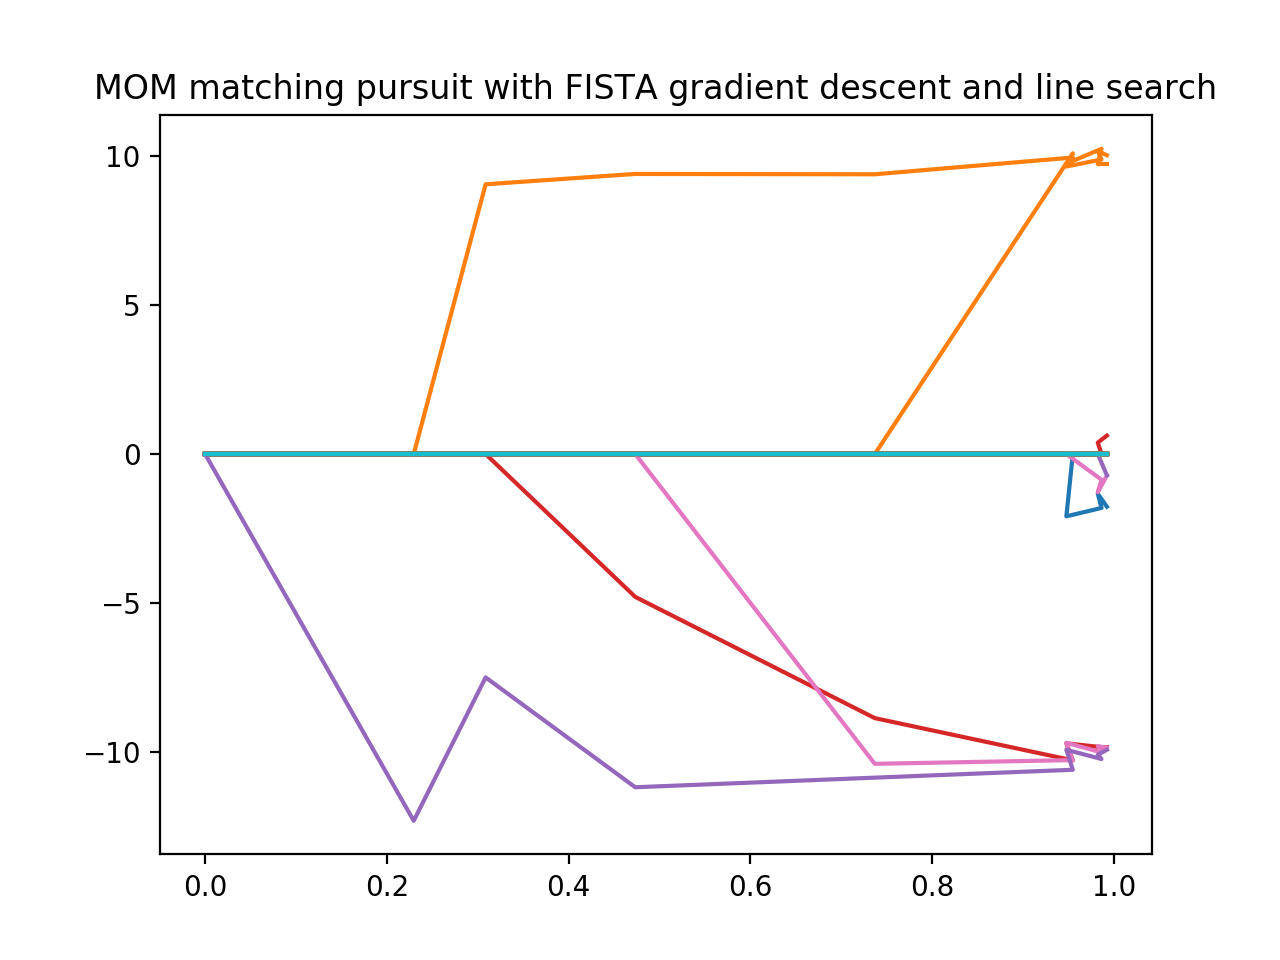

Non-zero elements of t_0 : [[ 10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [ -1.00948259]
 [  0.18441584]
 [-10.        ]
 [-10.        ]
 [  0.05554498]
 [ -0.05025918]]
Elements of t_0 selected first by the algorithm : [[ 10.        ]
 [  0.18441584]
 [-10.        ]
 [ -1.83939721]
 [ 10.        ]
 [-10.        ]
 [-10.        ]
 [ -1.00948259]]
Approximation of t_0 : [[ 1.00520277e+01]
 [-1.96729915e+00]
 [ 1.04690523e+01]
 [-9.84521007e+00]
 [-1.26144818e+00]
 [ 9.35665850e-03]
 [-9.89625876e+00]
 [-9.83956033e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


<IPython.core.display.Javascript object>


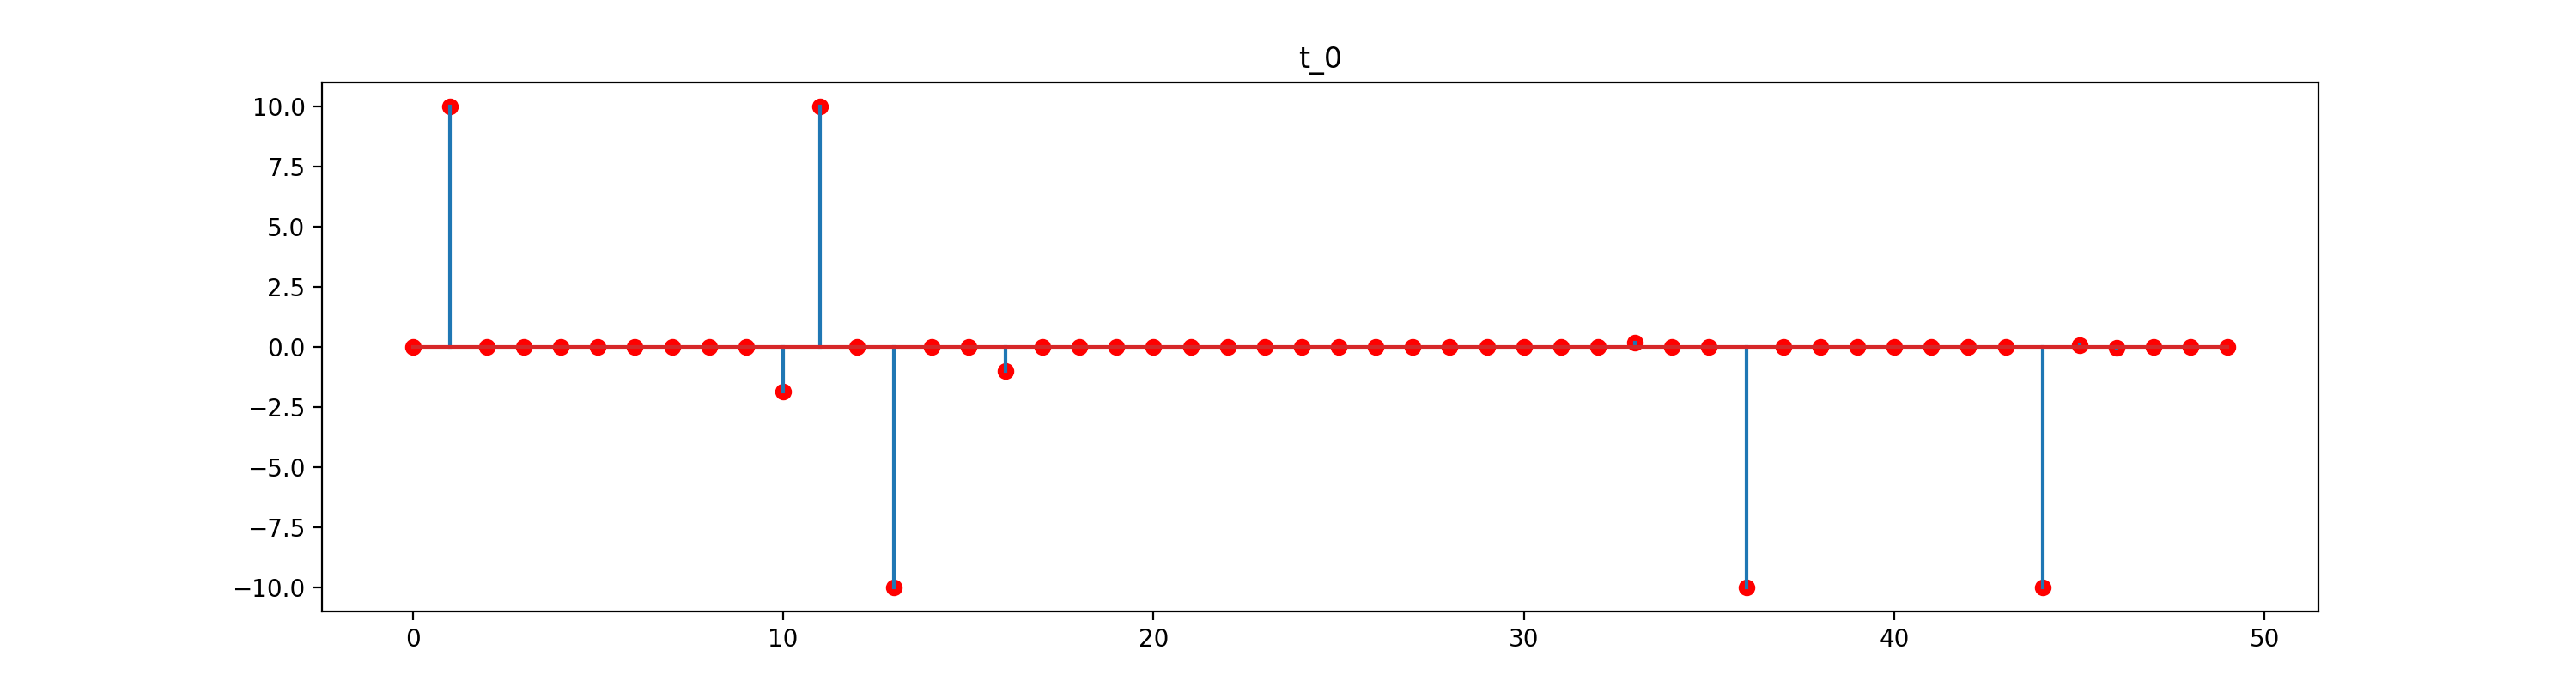

<IPython.core.display.Javascript object>


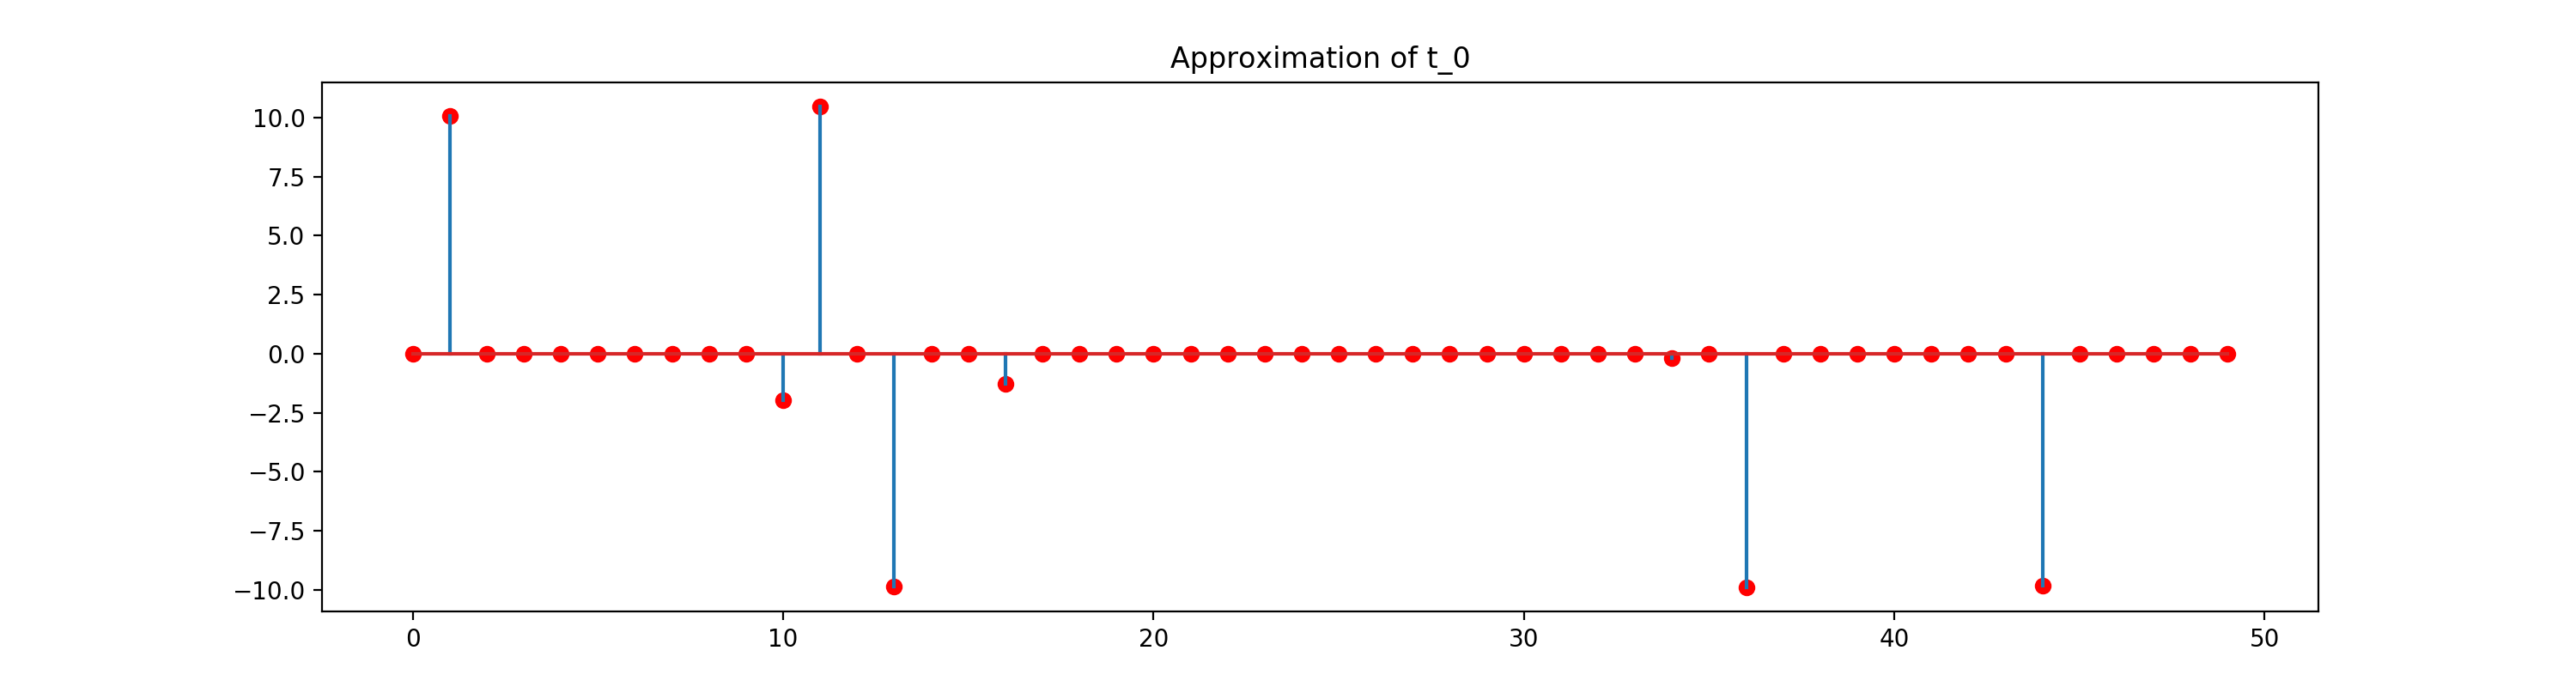

In [42]:
A,B = LS_FISTA_MOM_matching_pursuit(X,Y,8,iter_max,10,0.5)

xx  =  np.sum(np.abs(B), axis = 1)
xx /= xx[ - 1]

plt.plot(xx[ : - 1],B[ : - 1])
plt.title("MOM matching pursuit with FISTA gradient descent and line search")
plt.show()

detec_supp_test(t_0,A,sparsity)
graph_supp_detection(t_0,B)